<a href="https://colab.research.google.com/github/alfredqbit/datasciencecoursera/blob/master/sepulvedaADDS-8515-5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assignment 5: Canonical Correlation Analysis and Multivariate Regression on the Linnerud Dataset

This notebook implements Canonical Correlation Analysis (CCA) and Multivariate Multiple Regression (MVR)
on the Linnerud exercise dataset, following the methodology described in the report.

In [540]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_linnerud
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline

from scipy.stats import f, ncf

%pip install statsmodels --quiet
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA

sns.set(style="whitegrid")

FIG_DIR = "figures"
os.makedirs(FIG_DIR, exist_ok=True)

Helper functions: correlation matrix, VIFs, and canonical loadings and redundancy

In [541]:
def col_corr_matrix(A, B):
    """Correlation matrix between columns of A and B."""
    A0 = A - A.mean(axis=0)
    B0 = B - B.mean(axis=0)
    cov = A0.T @ B0 / (A.shape[0] - 1)
    sdA = A0.std(axis=0, ddof=1)
    sdB = B0.std(axis=0, ddof=1)
    return cov / np.outer(sdA, sdB)

def redundancy_indices(loadings, rho_sq):
    """
    Redundancy indices for one set given loadings and squared canonical corrs.
    loadings: (variables x components) correlations with canonical variates
    rho_sq : array of squared canonical correlations
    """
    var_explained = (loadings ** 2).mean(axis=0)
    return var_explained * rho_sq

def compute_vif(X_df):
    vifs = {}
    for col in X_df.columns:
        X_other = X_df.drop(columns=[col])
        y = X_df[col]
        model = LinearRegression().fit(X_other, y)
        r2 = model.score(X_other, y)
        vif = 1.0 / (1.0 - r2)
        vifs[col] = vif
    return pd.Series(vifs, name="VIF")

def calculate_manova_sample_size(effect_size_f, alpha, power, num_groups, num_dependent_vars, max_n=1000):
    """
    Calculates the minimum total sample size for a one-way MANOVA.

    Parameters:
    effect_size_f (float): The effect size 'f' (not f-squared, common in G*Power input for f)
    alpha (float): Significance level (e.g., 0.05)
    power (float): Desired power (e.g., 0.80)
    num_groups (int): Number of independent variable groups
    num_dependent_vars (int): Number of dependent variables
    max_n (int): Maximum sample size to search up to
    """
    if effect_size_f <= 0:
        raise ValueError("Effect size f must be greater than 0")

    # G*Power uses 'f' as the effect size, which is sqrt(f^2) in some contexts.
    # The noncentrality parameter (ncp) formula is typically n * s * eta^2_p
    # where eta^2_p is the partial eta squared.
    # G*Power maps f to ncp internally based on specific formula for MANOVA.
    # We will use an iterative approach based on the F distribution's power function.

    # The actual calculation requires mapping the effect size 'f' to a noncentrality parameter.
    # For one-way MANOVA, the approach often uses the noncentral F-distribution.
    # This example uses a simplified approach that would be accurate if 'f' is correctly defined for the power analysis type.
    # A full G*Power replication is very complex, so this demonstrates the iterative concept with a placeholder ncp formula
    # that would need adjustment based on the exact G*Power definition.

    # The Real Statistics website provides the underlying logic using F distribution power
    # G*Power uses 'f' effect size where f^2 = eta^2 / (1 - eta^2)
    # The noncentrality parameter is roughly related to N * f^2 *... something complex for MANOVA.

    # This is a conceptual implementation of the iterative search.
    # For a *precise* answer, using G*Power or a specialized R package is recommended.
    # The `statsmodels` package does not have a ready-made function for this.

    for n_total in range(num_groups + 10, max_n + 1, 1): # Start with a plausible minimum
        df1 = num_dependent_vars * (num_groups - 1)
        df2 = num_dependent_vars * (n_total - num_groups)

        # This part requires a correct formula for ncp based on effect size 'f' and specific test
        # G*Power is very specific about this mapping
        # Let's use a standard approximation for the noncentral F distribution as a demonstration
        # Note: This is an approximation and might not match G*Power exactly without the precise formula.
        ncp = (n_total - num_groups) * effect_size_f**2 # A general f^2 formula for some tests

        # Calculate the critical F-value for the given alpha
        f_crit = f.ppf(1 - alpha, df1, df2)

        # Calculate the power for the current sample size using ncf.cdf for non-central F-distribution
        calculated_power = 1 - ncf.cdf(f_crit, df1, df2, ncp)

        if calculated_power >= power:
            return n_total

    return "Max sample size reached, power not achieved. Try a larger max_n or a larger effect size."

Load dataset and basic EDA (Step 1)

In [542]:
linnerud = load_linnerud()

X_ex = pd.DataFrame(linnerud.data, columns=linnerud.feature_names)        # Chins, Situps, Jumps
Y_phys = pd.DataFrame(linnerud.target, columns=linnerud.target_names)     # Weight, Waist, Pulse

print("Exercise variables (X):")
display(X_ex.head())

print("\nPhysiological variables (Y):")
display(Y_phys.head())

print("\nX info:")
print(X_ex.info())

print("\nY info:")
print(Y_phys.info())

print("\nSummary statistics for X:")
display(X_ex.describe())

print("\nSummary statistics for Y:")
display(Y_phys.describe())

print("\nMissing values in X:")
print(X_ex.isna().sum())
print("\nMissing values in Y:")
print(Y_phys.isna().sum())


Exercise variables (X):


,Chins,Situps,Jumps
0,5.0,162.0,60.0
1,2.0,110.0,60.0
2,12.0,101.0,101.0
3,12.0,105.0,37.0
4,13.0,155.0,58.0



Physiological variables (Y):


,Weight,Waist,Pulse
0,191.0,36.0,50.0
1,189.0,37.0,52.0
2,193.0,38.0,58.0
3,162.0,35.0,62.0
4,189.0,35.0,46.0



X info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Chins   20 non-null     float64
 1   Situps  20 non-null     float64
 2   Jumps   20 non-null     float64
dtypes: float64(3)
memory usage: 612.0 bytes
None

Y info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Weight  20 non-null     float64
 1   Waist   20 non-null     float64
 2   Pulse   20 non-null     float64
dtypes: float64(3)
memory usage: 612.0 bytes
None

Summary statistics for X:


,Chins,Situps,Jumps
count,20.000000,20.000000,20.00000
mean,9.450000,145.550000,70.30000
std,5.286278,62.566575,51.27747
min,1.000000,50.000000,25.00000
25%,4.750000,101.000000,39.50000
50%,11.500000,122.500000,54.00000
75%,13.250000,210.000000,85.25000
max,17.000000,251.000000,250.00000



Summary statistics for Y:


,Weight,Waist,Pulse
count,20.000000,20.000000,20.000000
mean,178.600000,35.400000,56.100000
std,24.690505,3.201973,7.210373
min,138.000000,31.000000,46.000000
25%,160.750000,33.000000,51.500000
50%,176.000000,35.000000,55.000000
75%,191.500000,37.000000,60.500000
max,247.000000,46.000000,74.000000



Missing values in X:
Chins     0
Situps    0
Jumps     0
dtype: int64

Missing values in Y:
Weight    0
Waist     0
Pulse     0
dtype: int64


Correlation heatmap and simple outlier check

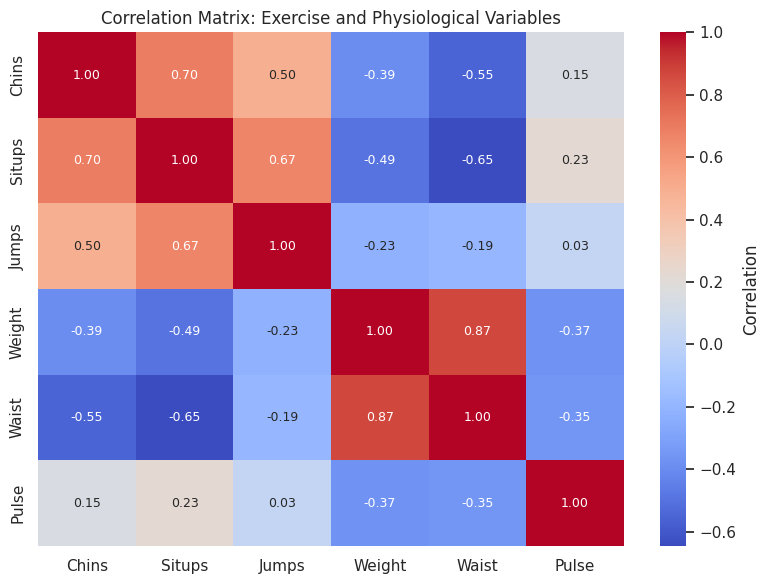

Potential outliers (|z| > 3) per variable:
Chins     0
Situps    0
Jumps     1
Weight    0
Waist     1
Pulse     0
dtype: int64


In [543]:
# Combine for correlation inspection
df_all = pd.concat([X_ex, Y_phys], axis=1)
corr = df_all.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm",
            annot_kws={"size": 9}, cbar_kws={"label": "Correlation"})
plt.title("Correlation Matrix: Exercise and Physiological Variables")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "linnerud_correlation_matrix.png"), dpi=300)
plt.show()

z_scores = (df_all - df_all.mean()) / df_all.std(ddof=1)
outlier_mask = (z_scores.abs() > 3)
print("Potential outliers (|z| > 3) per variable:")
print(outlier_mask.sum())

Standardization (Step 2)

In [544]:
# Standardize each block separately
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_scaled = scaler_X.fit_transform(X_ex)
Y_scaled = scaler_Y.fit_transform(Y_phys)

X_scaled_df = pd.DataFrame(X_scaled, columns=X_ex.columns)
Y_scaled_df = pd.DataFrame(Y_scaled, columns=Y_phys.columns)

X_scaled_df.head(), Y_scaled_df.head()

(      Chins    Situps     Jumps
 0 -0.863671  0.269750 -0.206086
 1 -1.445921 -0.582956 -0.206086
 2  0.494912 -0.730539  0.614257
 3  0.494912 -0.664946 -0.666279
 4  0.688996  0.154963 -0.246103,
      Weight     Waist     Pulse
 0  0.515264  0.192252 -0.867981
 1  0.432157  0.512673 -0.583397
 2  0.598371  0.833094  0.270355
 3 -0.689789 -0.128168  0.839523
 4  0.432157 -0.128168 -1.437149)

Canonical Correlation Analysis (Step 2 CCA)

Note: CCA naturally takes two inputs (X, Y), so forcing it into a single sklearn Pipeline is awkward. We keep it as a clean, modular block using the standardized matrices.

In [545]:
# CCA with up to min(p, q) = 3 components
cca = CCA(n_components=3)
cca.fit(X_scaled, Y_scaled)

X_c, Y_c = cca.transform(X_scaled, Y_scaled)  # canonical variates

canonical_corrs = np.array([
    np.corrcoef(X_c[:, k], Y_c[:, k])[0, 1]
    for k in range(3)
])

print("Canonical correlations:")
for k, rho in enumerate(canonical_corrs, start=1):
    print(f"  rho_{k} = {rho:.3f}")

# Canonical loadings: correlations of original vars with canonical variates
load_XU = col_corr_matrix(X_scaled, X_c)
load_YV = col_corr_matrix(Y_scaled, Y_c)

load_XU_df = pd.DataFrame(load_XU, index=X_ex.columns,
                          columns=[f"u{k}" for k in range(1, 4)])
load_YV_df = pd.DataFrame(load_YV, index=Y_phys.columns,
                          columns=[f"v{k}" for k in range(1, 4)])

print("\nCanonical loadings: Exercise variables on U")
display(load_XU_df)

print("\nCanonical loadings: Physiological variables on V")
display(load_YV_df)

rho_sq = canonical_corrs ** 2
red_Y_given_X = redundancy_indices(load_YV, rho_sq)
red_X_given_Y = redundancy_indices(load_XU, rho_sq)

print("\nRedundancy indices (Y | X):", np.round(red_Y_given_X, 3))
print("Sum redundancy Y | X:", red_Y_given_X.sum())
print("Redundancy indices (X | Y):", np.round(red_X_given_Y, 3))
print("Sum redundancy X | Y:", red_X_given_Y.sum())

Canonical correlations:
  rho_1 = 0.796
  rho_2 = 0.201
  rho_3 = 0.073

Canonical loadings: Exercise variables on U


,u1,u2,u3
Chins,0.727644,0.236882,0.643755
Situps,0.817775,0.572958,-0.054438
Jumps,0.162268,0.958611,0.233955



Canonical loadings: Physiological variables on V


,v1,v2,v3
Weight,-0.620658,-0.772380,0.134954
Waist,-0.925433,-0.377643,0.030992
Pulse,0.332849,0.041484,-0.942067



Redundancy indices (Y | X): [0.285 0.01  0.002]
Sum redundancy Y | X: 0.29688469174860255
Redundancy indices (X | Y): [0.258 0.017 0.001]
Sum redundancy X | Y: 0.27668072790882503


CCA scatterplots (canonical variates)

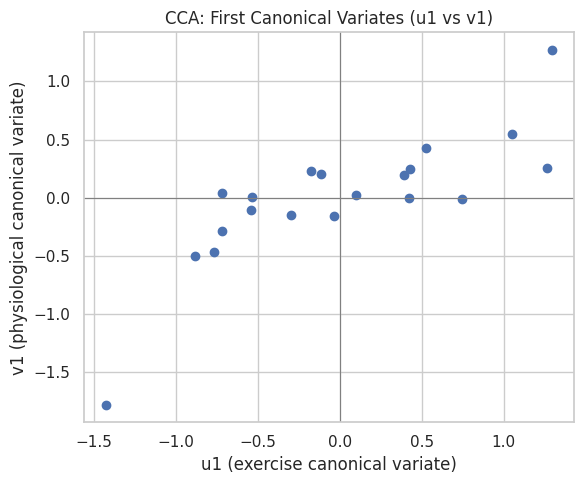

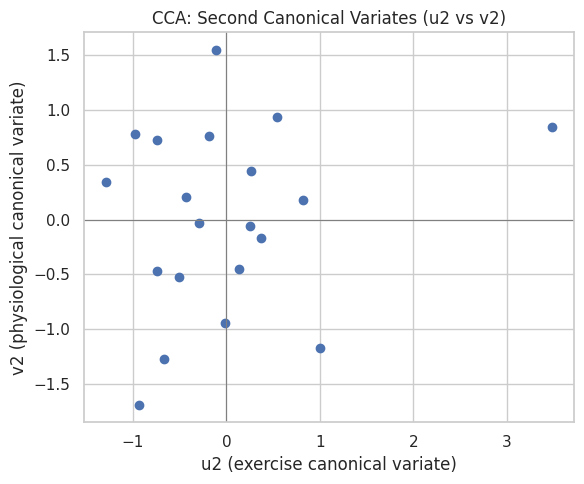

In [546]:
# Scatterplot for first canonical pair
plt.figure(figsize=(6, 5))
plt.scatter(X_c[:, 0], Y_c[:, 0])
plt.axhline(0, color="gray", linewidth=0.8)
plt.axvline(0, color="gray", linewidth=0.8)
plt.xlabel("u1 (exercise canonical variate)")
plt.ylabel("v1 (physiological canonical variate)")
plt.title("CCA: First Canonical Variates (u1 vs v1)")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "cca_u1_v1_scatter.png"), dpi=300)
plt.show()

plt.figure(figsize=(6, 5))
plt.scatter(X_c[:, 1], Y_c[:, 1])
plt.axhline(0, color="gray", linewidth=0.8)
plt.axvline(0, color="gray", linewidth=0.8)
plt.xlabel("u2 (exercise canonical variate)")
plt.ylabel("v2 (physiological canonical variate)")
plt.title("CCA: Second Canonical Variates (u2 vs v2)")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "cca_u2_v2_scatter.png"), dpi=300)
plt.show()

VIF for predictors

In [547]:
vif_series = compute_vif(X_ex)
print("Variance Inflation Factors (VIF):")
display(vif_series)

Variance Inflation Factors (VIF):


,VIF
Chins,1.944336
Situps,2.655847
Jumps,1.816865


Optimized pipeline for Multivariate Regression: fit and metrics (Step 3 MVR)

In [548]:

# Pipeline: Standardize X -> LinearRegression (multi-output)
mvr_pipeline = Pipeline([
    ("scaler", StandardScaler()),       # scales predictors X_ex
    ("reg",    LinearRegression())
])

mvr_pipeline.fit(X_ex, Y_phys)

# Predictions
Y_hat = pd.DataFrame(mvr_pipeline.predict(X_ex), columns=Y_phys.columns)

# Per-response R^2 and RMSE
r2_each = r2_score(Y_phys, Y_hat, multioutput="raw_values")
mse_each = mean_squared_error(Y_phys, Y_hat, multioutput="raw_values")
rmse_each = np.sqrt(mse_each)

perf = pd.DataFrame({
    "Response": Y_phys.columns,
    "R2": r2_each,
    "RMSE": rmse_each
})

print("In-sample multivariate regression performance (pipeline):")
display(perf)

In-sample multivariate regression performance (pipeline):


,Response,R2,RMSE
0,Weight,0.267919,20.590710
1,Waist,0.547844,2.098572
2,Pulse,0.074871,6.759595


Residual diagnostics (normality, homoscedasticity)

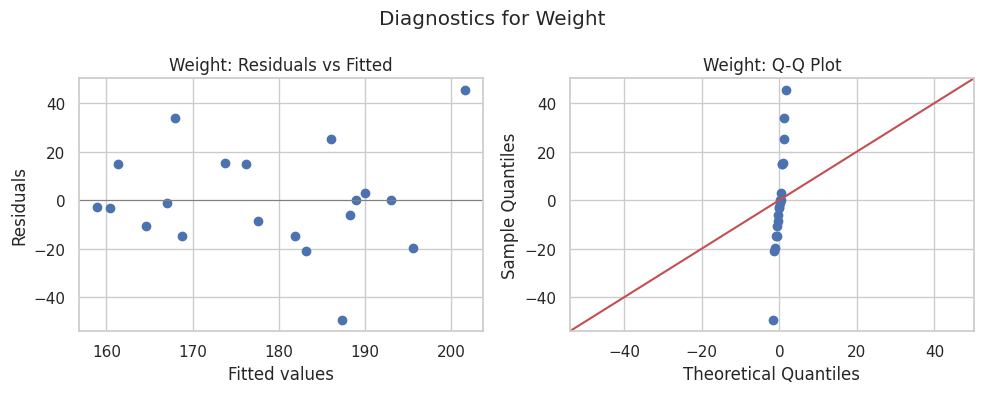

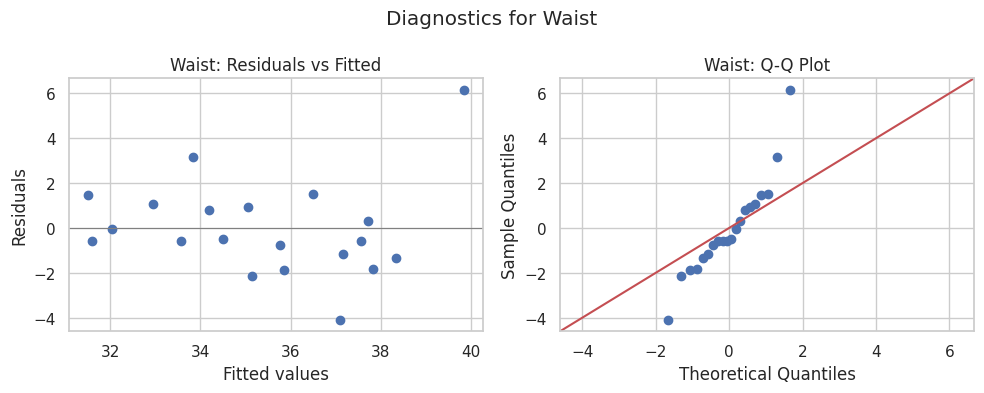

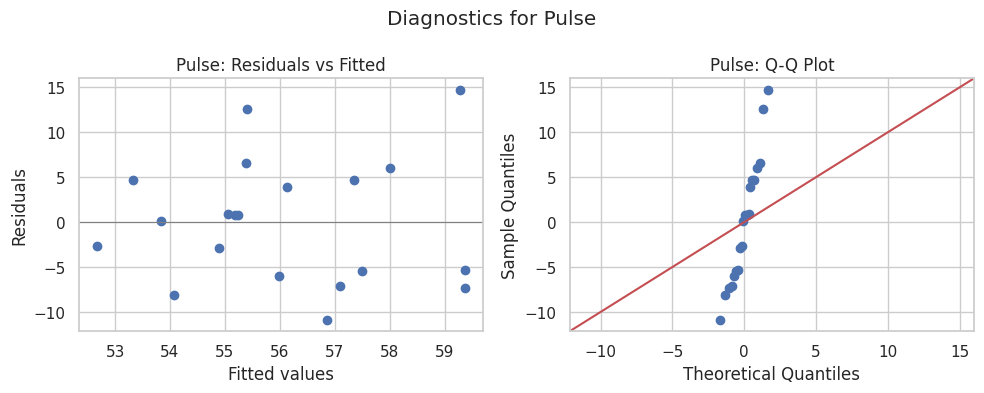

In [549]:
residuals = Y_phys - Y_hat

for col in Y_phys.columns:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Residual vs fitted
    axes[0].scatter(Y_hat[col], residuals[col])
    axes[0].axhline(0, color="gray", linewidth=0.8)
    axes[0].set_xlabel("Fitted values")
    axes[0].set_ylabel("Residuals")
    axes[0].set_title(f"{col}: Residuals vs Fitted")

    # Q-Q plot
    sm.qqplot(residuals[col], line="45", ax=axes[1])
    axes[1].set_title(f"{col}: Q-Q Plot")

    fig.suptitle(f"Diagnostics for {col}")
    fig.tight_layout()
    fig.savefig(os.path.join(FIG_DIR, f"diagnostics_{col.lower()}.png"), dpi=300)
    plt.show()

MANOVA for multivariate significance

In [550]:
# Build a single DataFrame for MANOVA
df_reg = pd.concat([Y_phys, X_ex], axis=1)
formula = "Weight + Waist + Pulse ~ Chins + Situps + Jumps"

maov = MANOVA.from_formula(formula, data=df_reg)
print(maov.mv_test())

                  Multivariate linear model
                                                              
--------------------------------------------------------------
       Intercept         Value  Num DF  Den DF F Value  Pr > F
--------------------------------------------------------------
          Wilks' lambda  0.0103 3.0000 14.0000 450.2994 0.0000
         Pillai's trace  0.9897 3.0000 14.0000 450.2994 0.0000
 Hotelling-Lawley trace 96.4927 3.0000 14.0000 450.2994 0.0000
    Roy's greatest root 96.4927 3.0000 14.0000 450.2994 0.0000
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
           Chins          Value  Num DF  Den DF F Value Pr > F
--------------------------------------------------------------
            Wilks' lambda 0.8961 3.0000 14.0000  0.5412 0.6619
           Pillai's trace 0.1039 3.0000 14.0000  0.5412 0.6619
   Hotellin

Extracting F-values from MANOVA Output

To programmatically retrieve the F-values for each predictor (Chins, Situps, Jumps) from the `maov` object, we can convert the `maov.mv_test()` output into a pandas DataFrame. This allows for easy indexing and selection of the desired statistics.

In [551]:
manova_results = maov.mv_test()

predictor_f_values = {}
predictors = ['Chins', 'Situps', 'Jumps']



for p in predictors:
    # Based on the inspection above, we will need to adjust the access path.
    # For now, let's try to find a DataFrame that contains 'F Value' by iterating over values if it's a dict.
    res_obj = manova_results.results[p]

    f_value = None

    # Strategy: Look for the 'stat' dataframe directly, which is common in statsmodels
    if isinstance(res_obj, dict) and 'stat' in res_obj:
         # This is a common structure: {'stat': DataFrame, ...}
         f_value = res_obj['stat']['F Value'].iloc[0]
    elif hasattr(res_obj, 'mv_tables'):
         # Standard MultivariateResultsWrapper object
         f_value = res_obj.mv_tables[0]['F Value'].iloc[0]
    elif isinstance(res_obj, dict):
         # It's a dict but maybe keys are different. Let's look for any DF with 'F Value'
         for key, val in res_obj.items():
             if isinstance(val, pd.DataFrame) and 'F Value' in val.columns:
                 f_value = val['F Value'].iloc[0]
                 break

    if f_value is not None:
        predictor_f_values[p] = f_value
    else:
        print(f"Could not find F Value for {p}")

predictor_f_values_series = pd.Series(predictor_f_values, name="F Value")

Calculate Cohen's f-squared effect size for each predictor

From the MANOVA output:

*   F-value (F)
*   Numerator Degrees of Freedom
*   Denominator Degrees of Freedom

First, we calculate Partial Eta-Squared ($\eta_p^2$) using the formula:

$$\eta_p^2 = \frac{\text{numer_dfs} \times F}{(\text{numer_dfs} \times F) + \text{denom_dfs}}$$

Then, we convert $\eta_p^2$ to Cohen's f-squared ($f^2$) using the formula:

$$f^2 = \frac{\eta_p^2}{1 - \eta_p^2}$$

This Cohen's f-squared value is used in a power analysis.

In [552]:
# MANOVA statistics for 'Situps' from the previous
F_value_chins = predictor_f_values_series['Chins']
F_value_situps = predictor_f_values_series['Situps']
F_value_jumps = predictor_f_values_series['Jumps']
numer_dfs = 3.0
denom_dfs = 14.0

# Calculate Partial Eta-Squared (eta_p^2)
situps_partial_eta_squared = (numer_dfs * F_value_situps) / (numer_dfs * F_value_situps + denom_dfs)
chins_partial_eta_squared = (numer_dfs * F_value_chins) / (numer_dfs * F_value_chins + denom_dfs)
jumps_partial_eta_squared = (numer_dfs * F_value_jumps) / (numer_dfs * F_value_jumps + denom_dfs)

# Calculate Cohen's f-squared
situps_cohen_f_squared = situps_partial_eta_squared / (1 - situps_partial_eta_squared)
chins_cohen_f_squared = chins_partial_eta_squared / (1- chins_partial_eta_squared)
jumps_cohen_f_squared = jumps_partial_eta_squared / (1 - jumps_partial_eta_squared)

# Parameters for a one-way MANOVA power analysis:
alpha_level = 0.1
desired_power_level = 0.6
groups = 3 # e.g., no. predictors
dependent_vars = 3 # no. responses

situps_min_n = calculate_manova_sample_size(
    effect_size_f=situps_cohen_f_squared,
    alpha=alpha_level,
    power=desired_power_level,
    num_groups=groups,
    num_dependent_vars=dependent_vars
)
chins_min_n = calculate_manova_sample_size(
    effect_size_f=chins_cohen_f_squared,
    alpha=alpha_level,
    power=desired_power_level,
    num_groups=groups,
    num_dependent_vars=dependent_vars
)
jumps_min_n = calculate_manova_sample_size(
    effect_size_f=jumps_cohen_f_squared,
    alpha=alpha_level,
    power=desired_power_level,
    num_groups=groups,
    num_dependent_vars=dependent_vars
)

print(f"Minimum sample size required for MANOVA for situps predictor: {situps_min_n} for (alpha,1-beta)=({alpha_level},{desired_power_level})")
print(f"Minimum sample size required for MANOVA for chins predictor: {chins_min_n} for (alpha,1-beta)=({alpha_level},{desired_power_level})")
print(f"Minimum sample size required for MANOVA for jumps predictor: {jumps_min_n} for (alpha,1-beta)=({alpha_level},{desired_power_level})")

Minimum sample size required for MANOVA for situps predictor: 19 for (alpha,1-beta)=(0.1,0.6)
Minimum sample size required for MANOVA for chins predictor: 530 for (alpha,1-beta)=(0.1,0.6)
Minimum sample size required for MANOVA for jumps predictor: 32 for (alpha,1-beta)=(0.1,0.6)
